# 04. Virtual Try-on (Food Theme)

This notebook demonstrates how to use Amazon Nova Canvas Virtual Try-On feature with a food theme.
The main function can process multiple mergeStyle options at once.

## Key Features
- Function-based modular design
- Support for multiple mergeStyle options in one execution
- Automatic comparison and analysis

## 1. Import Required Libraries

In [1]:
def import_libraries():
    """
    Import all required libraries for the Virtual Try-On demo with food theme
    """
    global boto3, json, base64, io, Image, plt, randint, np, os, Dict, Any
    
    import boto3
    import json
    import base64
    import io
    from PIL import Image
    import matplotlib.pyplot as plt
    from random import randint
    import numpy as np
    import os
    from typing import Dict, Any
    
    # Configure matplotlib for inline display
    plt.rcParams['figure.figsize'] = (15, 5)
    
    print("✅ All libraries imported successfully")
    return True

# Execute library import
import_libraries()
%matplotlib inline

✅ All libraries imported successfully


## 2. Setup Bedrock Client

In [2]:
# 📌 replace with your aws profile
aws_profile = 'your-aws-profile'

def setup_bedrock_client(region='us-east-1'):
    """
    Setup Bedrock client with specified profile and region
    
    Args:
        profile_name (str): AWS profile name
        region (str): AWS region
    
    Returns:
        boto3.client: Bedrock runtime client
    """
    try:
        bedrock = boto3.client('bedrock-runtime', region_name=region)
        print(f"✅ Bedrock client created successfully")
        print(f"Region: {region}")
        return bedrock
    except Exception as e:
        print(f"❌ Failed to create Bedrock client: {e}")
        return None

# Setup global bedrock client
bedrock_client = setup_bedrock_client()

✅ Bedrock client created successfully
Region: us-east-1


## 3. Define Utility Functions

In [3]:
def encode_image_to_base64(image_path: str) -> str:
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def setup_image_paths_and_encode(source_path: str, reference_path: str):
    """Setup image paths and encode them to base64"""
    try:
        print(f"Source image: {source_path}")
        print(f"Reference image: {reference_path}")
        
        source_base64 = encode_image_to_base64(source_path)
        reference_base64 = encode_image_to_base64(reference_path)
        
        print("✅ Image encoding completed successfully")
        return source_base64, reference_base64, True
    except Exception as e:
        print(f"❌ Image encoding error: {e}")
        return None, None, False

def preview_original_images(source_path: str, reference_path: str):
    """Preview original source and reference images"""
    try:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        source_img = Image.open(source_path)
        axes[0].imshow(source_img)
        axes[0].set_title("Source Image (Empty Plate)", fontsize=14)
        axes[0].axis('off')
        
        reference_img = Image.open(reference_path)
        axes[1].imshow(reference_img)
        axes[1].set_title("Reference Image (Hamburger)", fontsize=14)
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Source image size: {source_img.size}")
        print(f"Reference image size: {reference_img.size}")
        
    except Exception as e:
        print(f"❌ Error previewing images: {e}")

print("✅ Utility functions defined successfully")

✅ Utility functions defined successfully


## 4. Image Processing Function

In [4]:
def process_nova_response(response: Dict[str, Any], original_image_path: str, style_name: str = ""):
    """Process Nova Canvas response and visualize results"""
    if not response:
        print("No response received.")
        return
    
    print("Response keys: ", list(response.keys()))
    
    images = response.get('images', [])
    mask_data = response.get('maskImage', None)
    
    if images:
        for i, image_data in enumerate(images):
            img_bytes = base64.b64decode(image_data)
            img = Image.open(io.BytesIO(img_bytes))
            
            os.makedirs("img/output", exist_ok=True)
            suffix = f"_{style_name}" if style_name else ""
            output_path = f"img/output/hamburger_on_plate{suffix}_{i}.png"
            img.save(output_path)
            
            mask_img = None
            if mask_data:
                mask_bytes = base64.b64decode(mask_data)
                mask_img = Image.open(io.BytesIO(mask_bytes))
                mask_path = f"img/output/mask_hamburger{suffix}_{i}.png"
                mask_img.save(mask_path)
                print(f"Mask image saved to '{mask_path}'")
            
            if mask_img:
                fig, axes = plt.subplots(1, 3, figsize=(20, 5))
                
                original_img = Image.open(original_image_path)
                axes[0].imshow(original_img)
                axes[0].set_title("Original (Empty Plate)", fontsize=14)
                axes[0].axis('off')
                
                axes[1].imshow(mask_img, cmap='gray')
                axes[1].set_title("Mask (Black=Modified, White=Preserved)", fontsize=14)
                axes[1].axis('off')
                
                axes[2].imshow(img)
                title = f"Result{' (' + style_name + ')' if style_name else ''}"
                axes[2].set_title(title, fontsize=14)
                axes[2].axis('off')
                
                plt.tight_layout()
                plt.show()
            
            print(f"Result image saved to '{output_path}'")
            
            if mask_img:
                mask_array = np.array(mask_img.convert('L'))
                black_pixels = np.sum(mask_array < 128)
                white_pixels = np.sum(mask_array >= 128)
                total_pixels = mask_array.size
                
                print(f"Mask Analysis:")
                print(f"  - Modified: {black_pixels:,} pixels ({black_pixels/total_pixels*100:.1f}%)")
                print(f"  - Preserved: {white_pixels:,} pixels ({white_pixels/total_pixels*100:.1f}%)")
    else:
        print("No generated images found.")

print("✅ Image processing function defined")

✅ Image processing function defined


## 5. Preview Images Function

In [5]:
def preview_images(source_path, reference_path):
    """Preview original images before processing"""
    preview_original_images(source_path, reference_path)

print("✅ Preview function defined")

✅ Preview function defined


## 6. Nova API Call Function

In [6]:
def call_nova_api(source_base64, reference_base64, merge_style="SEAMLESS", mask_prompt="empty plate"):
    """Call Nova Canvas API for Virtual Try-On"""
    seed = randint(0, 2147483646)
    
    request_body = {
        "taskType": "VIRTUAL_TRY_ON",
        "virtualTryOnParams": {
            "sourceImage": source_base64,
            "referenceImage": reference_base64,
            "maskType": "PROMPT",
            "promptBasedMask": {
                "maskShape": "BOUNDING_BOX",
                "maskPrompt": mask_prompt
            },
            "mergeStyle": merge_style,
            "returnMask": True
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "quality": "premium",
            "cfgScale": 7.0,
            "seed": seed
        }
    }
    
    print(f"Making API call with {merge_style} style...")
    print(f"Seed: {seed}, Mask prompt: '{mask_prompt}'")
    
    try:
        response = bedrock_client.invoke_model(
            modelId='amazon.nova-canvas-v1:0',
            body=json.dumps(request_body),
            contentType='application/json'
        )
        
        response_body = json.loads(response['body'].read())
        print(f"✅ {merge_style} API call successful!")
        return response_body
        
    except Exception as e:
        print(f"❌ {merge_style} API call error: {e}")
        return None

print("✅ Nova API call function defined")

✅ Nova API call function defined


## 7. Main Function - Complete Virtual Try-On Demo

In [7]:
def run_virtual_tryon_demo(source_path, reference_path, merge_styles=["SEAMLESS", "BALANCED", "DETAILED"], mask_prompt="empty plate"):
    """
    Main function to run Virtual Try-On demo with multiple merge styles
    
    Args:
        source_path (str): Path to source image (empty plate)
        reference_path (str): Path to reference image (hamburger)
        merge_styles (list): List of merge styles to test
        mask_prompt (str): Text prompt for mask generation
    
    Returns:
        dict: Results summary
    """
    print("Starting Virtual Try-On Demo with food theme")
    print("=" * 50)
    
    results = {"success": [], "failed": [], "total_files": 0}
    
    # Step 1: Setup and encode images
    print("\n[Step 1] Setting up images...")
    source_base64, reference_base64, encode_success = setup_image_paths_and_encode(source_path, reference_path)
    
    if not encode_success:
        print("❌ Failed to encode images. Stopping execution.")
        return results
    
    # Step 2: Preview original images
    print("\n[Step 2] Previewing original images...")
    preview_images(source_path, reference_path)
    
    # Step 3: Process each merge style
    print(f"\n[Step 3] Processing {len(merge_styles)} merge styles...")
    
    for i, style in enumerate(merge_styles, 1):
        print(f"\n--- Processing {i}/{len(merge_styles)}: {style} ---")
        
        response = call_nova_api(source_base64, reference_base64, style, mask_prompt)
        
        if response:
            process_nova_response(response, source_path, style)
            results["success"].append(style)
        else:
            results["failed"].append(style)
    
    # Step 4: Summary
    print("\n[Step 4] Generating summary...")
    generate_summary(results)
    
    print("\nVirtual Try-On Demo completed!")
    print("=" * 50)
    
    return results

def generate_summary(results):
    """Generate and display summary of results"""
    output_dir = "img/output"
    if os.path.exists(output_dir):
        files = os.listdir(output_dir)
        results["total_files"] = len(files)
        
        print("Generated Files:")
        for file in sorted(files):
            file_path = os.path.join(output_dir, file)
            file_size = os.path.getsize(file_path)
            print(f"  - {file} ({file_size:,} bytes)")
    
    print(f"\nExecution Summary:")
    print(f"  - Successful: {len(results['success'])} ({', '.join(results['success'])})")
    print(f"  - Failed: {len(results['failed'])} ({', '.join(results['failed']) if results['failed'] else 'None'})")
    print(f"  - Total files: {results['total_files']}")

def quick_demo():
    """Quick demo with default paths and all merge styles"""
    source_path = "img/background1-empty-plate.png"
    reference_path = "img/ref1-sole hamburger.png"
    return run_virtual_tryon_demo(source_path, reference_path)

print("✅ Main functions defined successfully")

✅ Main functions defined successfully


## 8. Execute Demo

### Option 1: Quick Demo (Default paths, all styles)

Starting Virtual Try-On Demo with food theme

[Step 1] Setting up images...
Source image: img/background1-empty-plate.png
Reference image: img/ref1-sole hamburger.png
✅ Image encoding completed successfully

[Step 2] Previewing original images...


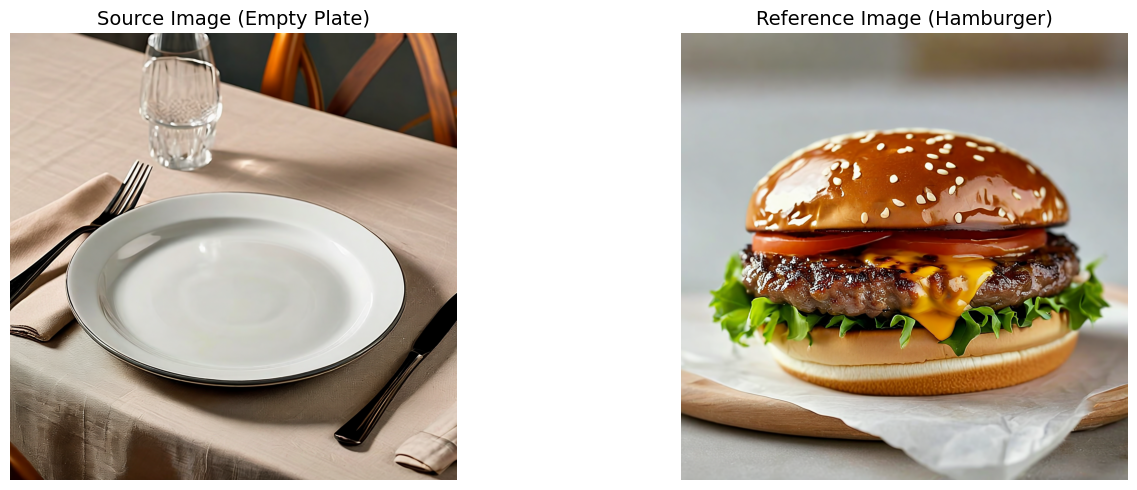

Source image size: (2048, 2048)
Reference image size: (2048, 2048)

[Step 3] Processing 3 merge styles...

--- Processing 1/3: SEAMLESS ---
Making API call with SEAMLESS style...
Seed: 70916883, Mask prompt: 'empty plate'
✅ SEAMLESS API call successful!
Response keys:  ['images', 'maskImage']
Mask image saved to 'img/output/mask_hamburger_SEAMLESS_0.png'


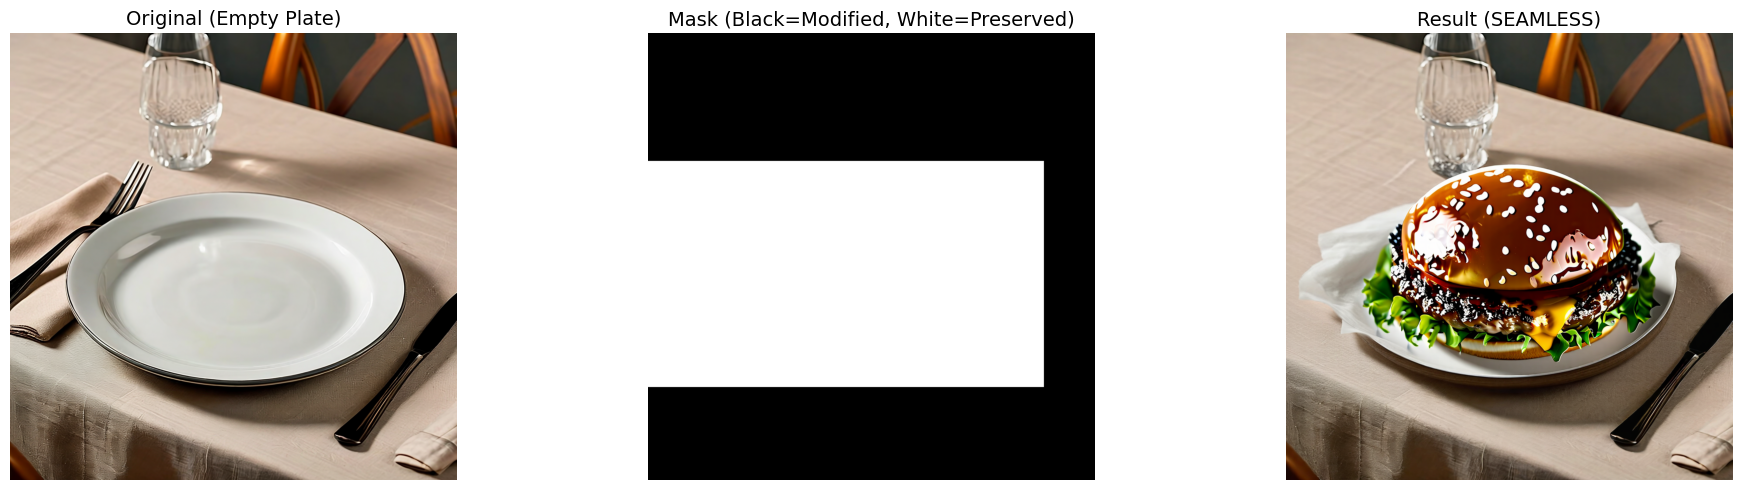

Result image saved to 'img/output/hamburger_on_plate_SEAMLESS_0.png'
Mask Analysis:
  - Modified: 2,315,000 pixels (55.2%)
  - Preserved: 1,879,304 pixels (44.8%)

--- Processing 2/3: BALANCED ---
Making API call with BALANCED style...
Seed: 969378890, Mask prompt: 'empty plate'
✅ BALANCED API call successful!
Response keys:  ['images', 'maskImage']
Mask image saved to 'img/output/mask_hamburger_BALANCED_0.png'


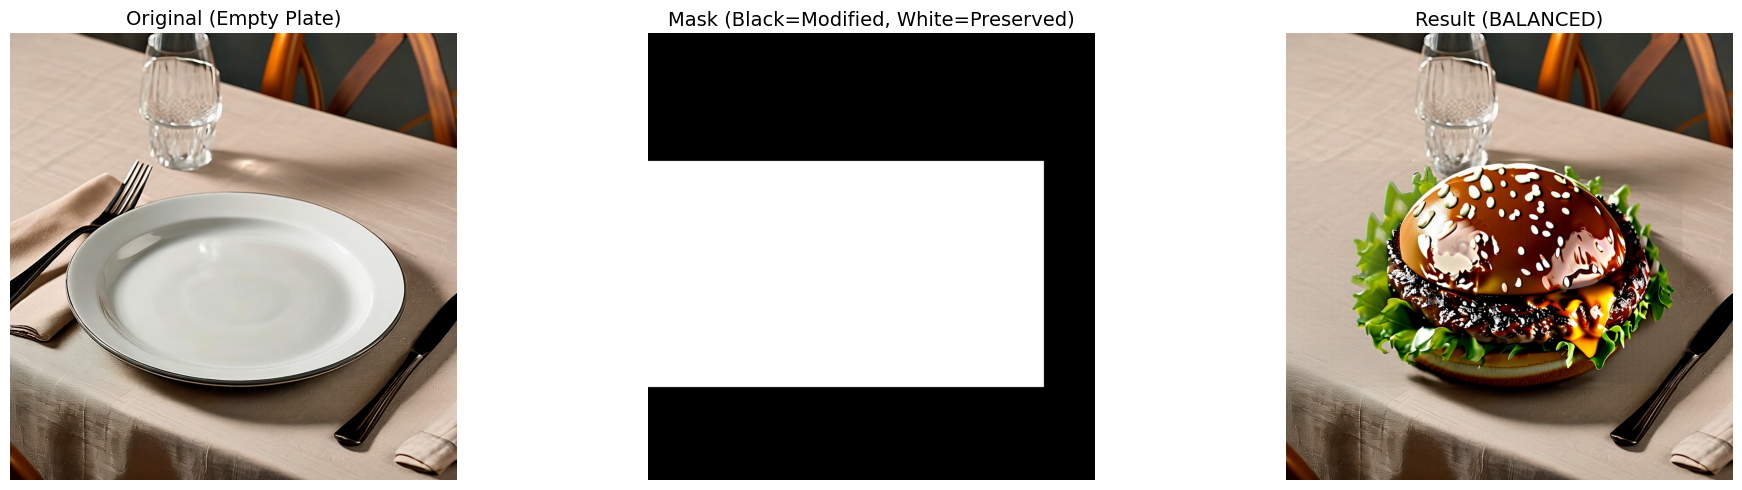

Result image saved to 'img/output/hamburger_on_plate_BALANCED_0.png'
Mask Analysis:
  - Modified: 2,315,000 pixels (55.2%)
  - Preserved: 1,879,304 pixels (44.8%)

--- Processing 3/3: DETAILED ---
Making API call with DETAILED style...
Seed: 1137377896, Mask prompt: 'empty plate'
✅ DETAILED API call successful!
Response keys:  ['images', 'maskImage']
Mask image saved to 'img/output/mask_hamburger_DETAILED_0.png'


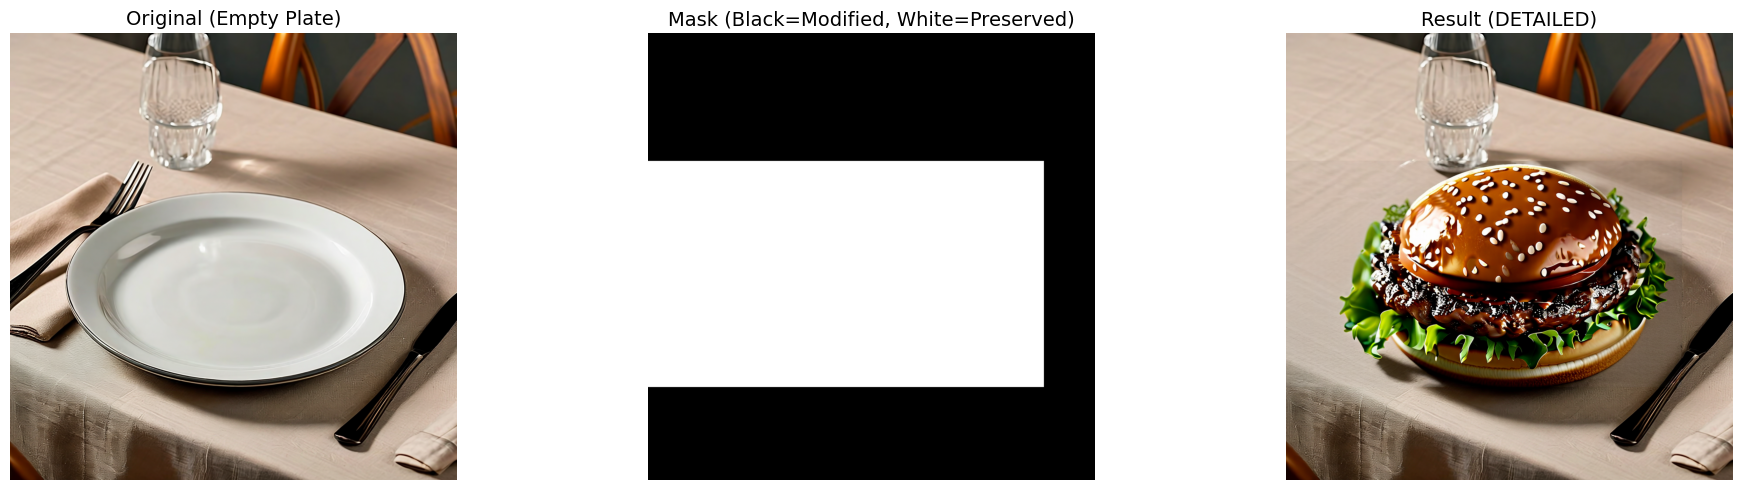

Result image saved to 'img/output/hamburger_on_plate_DETAILED_0.png'
Mask Analysis:
  - Modified: 2,315,000 pixels (55.2%)
  - Preserved: 1,879,304 pixels (44.8%)

[Step 4] Generating summary...
Generated Files:
  - hamburger_on_plate_BALANCED_0.png (5,630,645 bytes)
  - hamburger_on_plate_DETAILED_0.png (5,658,269 bytes)
  - hamburger_on_plate_SEAMLESS_0.png (4,099,088 bytes)
  - mask_hamburger_BALANCED_0.png (14,656 bytes)
  - mask_hamburger_DETAILED_0.png (14,656 bytes)
  - mask_hamburger_SEAMLESS_0.png (14,656 bytes)

Execution Summary:
  - Successful: 3 (SEAMLESS, BALANCED, DETAILED)
  - Failed: 0 (None)
  - Total files: 6

Virtual Try-On Demo completed!


In [8]:
# Run quick demo with all merge styles
results = quick_demo()

### Option 2: Custom Comparison Test (Specify your own parameters)

In [9]:
# Custom demo - modify these parameters as needed
custom_source = "your-source-img"
custom_reference = "your-reference-img"
custom_styles = ["SEAMLESS", "DETAILED"]  # Choose specific styles
custom_mask_prompt = "your-custom-mask-prompt"  # Customize mask prompt

# Run custom demo
# custom_results = run_virtual_tryon_demo(custom_source, custom_reference, custom_styles, custom_mask_prompt)

### Option 3: Single Style Test

In [10]:
# Test single merge style
single_source = "your-source-img"
single_reference = "your-reference-img"

# Run with single style
# single_results = run_virtual_tryon_demo(single_source, single_reference, ["SEAMLESS"])

## Reference

### Function Overview
- `run_virtual_tryon_demo()`: Main function that orchestrates the entire process
- `quick_demo()`: Convenience function with default settings
- `call_nova_api()`: Handles API calls to Nova Canvas
- `process_nova_response()`: Processes and visualizes API responses
- `setup_image_paths_and_encode()`: Handles image encoding
- `preview_original_images()`: Shows original images
- `generate_summary()`: Creates execution summary

### mergeStyle Options
- **SEAMLESS**: Natural composition, no visible seams
- **BALANCED**: Preserves original, may have slight seams  
- **DETAILED**: Best for fine details, logos, text

### Usage Examples
```python
# All styles
results = quick_demo()

# Custom paths and styles
results = run_virtual_tryon_demo(
    "/path/to/source.png",
    "/path/to/reference.png", 
    ["SEAMLESS", "DETAILED"]
)

# Single style
results = run_virtual_tryon_demo(
    source_path, reference_path, ["SEAMLESS"]
)
```